In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Carregar dataset
df = pd.read_csv("meds_train_alunos.csv")

In [14]:
# Selecionar colunas numéricas e rótulos
feature_columns = [col for col in df.columns if col.startswith('rssi') or col.startswith('delay')]
label_columns = ['lat', 'lon', 'indoor']

In [15]:
#Normalizar os dados
scaler_features = MinMaxScaler()
scaler_labels = MinMaxScaler()
data_features = scaler_features.fit_transform(df[feature_columns])
data_labels = scaler_labels.fit_transform(df[label_columns])

In [16]:
# Definição da cGAN
latent_dim = 20
num_features = len(feature_columns)
num_labels = len(label_columns)

#Gerador Condicional
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_labels, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_features),
            nn.Tanh()
        )

    def forward(self, z, labels):
        x = torch.cat((z, labels), dim=1)
        return self.model(x)

#Discriminador Condicional
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features + num_labels, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = torch.cat((x, labels), dim=1)
        return self.model(x)

In [17]:
#Criar modelos e otimizadores
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [18]:
#Treinamento
num_epochs = 10000
batch_size = 128

for epoch in range(num_epochs):
    #Criar batches de dados reais
    idx = np.random.randint(0, len(data_features), batch_size)
    real_features = torch.tensor(data_features[idx], dtype=torch.float32)
    real_labels = torch.tensor(data_labels[idx], dtype=torch.float32)

    #Criar labels (1 para reais, 0 para falsos)
    valid = torch.ones((batch_size, 1))
    fake = torch.zeros((batch_size, 1))

    #Treinar o Discriminador
    optimizer_D.zero_grad()
    z = torch.randn(batch_size, latent_dim)
    fake_features = generator(z, real_labels)
    real_loss = criterion(discriminator(real_features, real_labels), valid)
    fake_loss = criterion(discriminator(fake_features.detach(), real_labels), fake)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    #Treinar o Gerador
    optimizer_G.zero_grad()
    g_loss = criterion(discriminator(fake_features, real_labels), valid)
    g_loss.backward()
    optimizer_G.step()

    #Acompanhar treinamento
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: D_loss={d_loss.item():.4f}, G_loss={g_loss.item():.4f}")

Epoch 0: D_loss=1.3939, G_loss=0.7294
Epoch 1000: D_loss=1.3728, G_loss=0.7272
Epoch 2000: D_loss=1.2952, G_loss=0.8897
Epoch 3000: D_loss=1.1782, G_loss=1.0999
Epoch 4000: D_loss=1.1368, G_loss=1.1774
Epoch 5000: D_loss=1.1968, G_loss=1.2599
Epoch 6000: D_loss=1.1948, G_loss=1.6192
Epoch 7000: D_loss=0.9606, G_loss=2.1977
Epoch 8000: D_loss=0.9912, G_loss=2.3901
Epoch 9000: D_loss=0.9947, G_loss=2.0867


In [19]:
#Gerar amostras sintéticas
num_samples = 20325
z = torch.randn(num_samples, latent_dim)
label_conditions = torch.tensor(scaler_labels.transform(df[label_columns].sample(n=num_samples, replace=True).astype(float)), dtype=torch.float32)
generated_features = generator(z, label_conditions).detach().numpy()

In [20]:
#Reverter a normalização
generated_features = scaler_features.inverse_transform(generated_features)
generated_labels = scaler_labels.inverse_transform(label_conditions.numpy())

In [21]:
#Salvar os novos dados
df_generated = pd.DataFrame(np.hstack((generated_features, generated_labels)), columns=feature_columns + label_columns)
df_generated.to_csv("generated_data_CGAN.csv", index=False)

#### Verificacao

In [23]:
# Carregar os datasets
df_real = pd.read_csv("meds_train_alunos.csv")
df_sintetico = pd.read_csv("generated_data_CGAN.csv")

# Selecionar apenas as colunas numéricas (rssi_* e delay_*)
feature_columns = [col for col in df_real.columns if col.startswith('rssi') or col.startswith('delay')]

# Calcular estatísticas
stats_real = df_real[feature_columns].describe()
stats_sintetico = df_sintetico[feature_columns].describe()

In [24]:
# Comparar estatísticas lado a lado
print("\n📊 Estatísticas dos dados reais:")
print(stats_real)
print("\n📊 Estatísticas dos dados sintéticos:")
print(stats_sintetico)



📊 Estatísticas dos dados reais:
          rssi_1_1     rssi_1_2     rssi_1_3     rssi_2_1     rssi_2_2  \
count  6775.000000  6775.000000  6775.000000  6775.000000  6775.000000   
mean   -100.789923  -105.688802  -100.545198  -103.524786   -97.210290   
std      10.025728    10.397924     9.968138    13.367328     8.853480   
min    -115.000000  -115.000000  -115.000000  -115.000000  -115.000000   
25%    -107.650000  -115.000000  -107.148571  -115.000000  -102.202857   
50%    -103.040000  -110.425000   -99.750000  -108.430000   -97.170000   
75%     -93.455000   -97.350000   -93.340000   -96.817917   -92.080000   
max     -61.380000   -64.820000   -60.640000   -36.960000   -59.170000   

          rssi_2_3     rssi_3_1     rssi_3_2     rssi_3_3      delay_1  \
count  6775.000000  6775.000000  6775.000000  6775.000000  6775.000000   
mean    -97.193499   -93.644749   -93.353728  -107.478361     4.679410   
std       9.992950     7.688089     8.110877    11.003407     0.911469   
min 

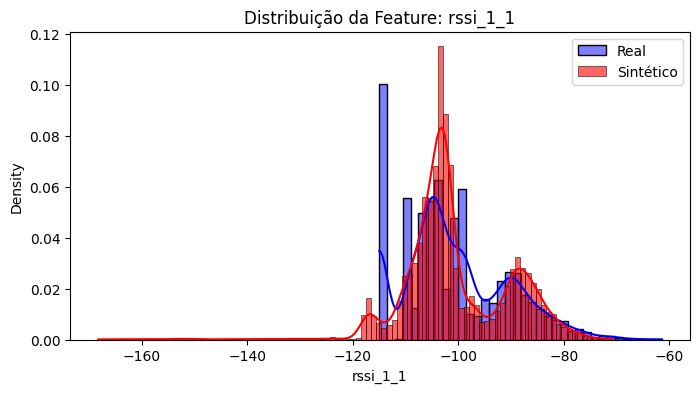

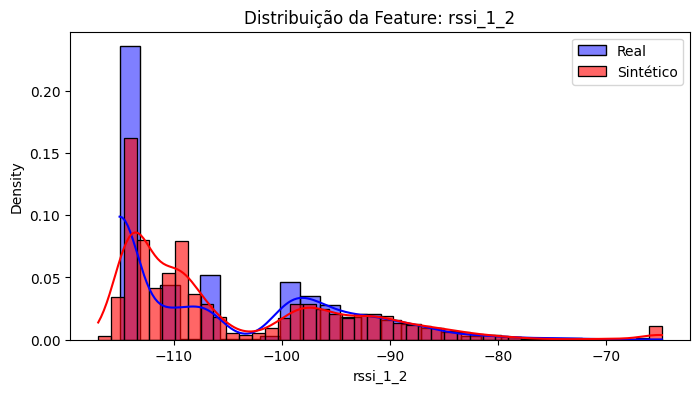

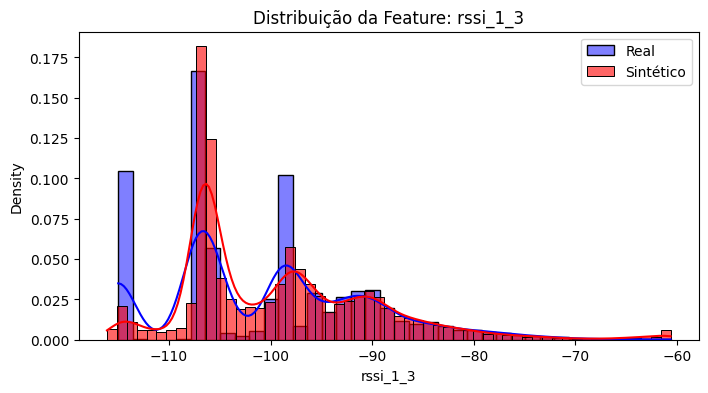

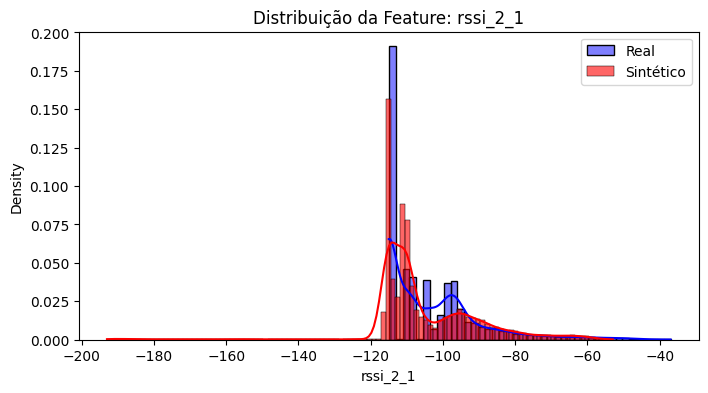

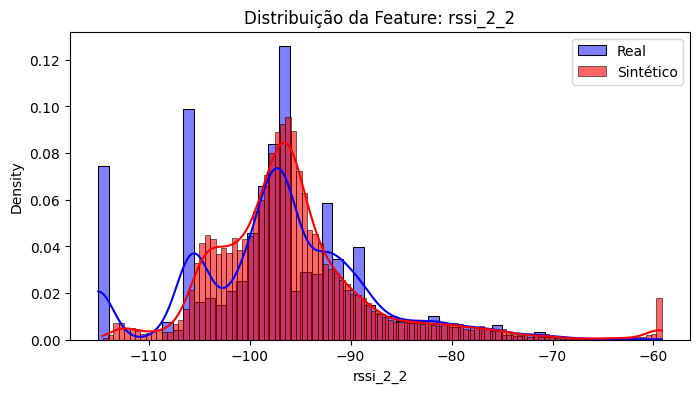

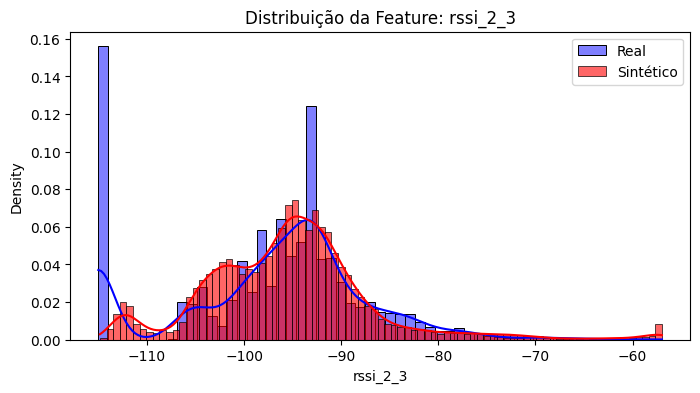

In [25]:
# Visualizar histogramas para algumas colunas
for col in feature_columns[:6]:  # Pegamos só algumas para não sobrecarregar os gráficos
    plt.figure(figsize=(8, 4))
    sns.histplot(df_real[col], label="Real", kde=True, color="blue", stat="density")
    sns.histplot(df_sintetico[col], label="Sintético", kde=True, color="red", stat="density", alpha=0.6)
    plt.title(f"Distribuição da Feature: {col}")
    plt.legend()
    plt.show()